# HuggingFace 커스텀 프로젝트
- model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task
- baseline 과 bucketing 적용시 비교

In [1]:
import tensorflow

import numpy as np

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, Trainer
from transformers import Trainer, TrainingArguments

import datasets
from datasets import load_dataset, Dataset, load_metric

import os
import torch
import gc

import matplotlib.pyplot as plt
import pandas as pd


import copy

print(tensorflow.__version__)
print(np.__version__)
print(transformers.__version__)
print(datasets.__version__)



2.6.0
1.21.4
4.11.3
1.14.0


## 함수 및 클래스

In [ ]:
# 중복 제거를 위한 인덱스 수집
def get_unique_indices(dataset):
    unique_texts = set()
    unique_indices = []
    for i, sample in enumerate(dataset):
        if sample['document'] not in unique_texts:
            unique_texts.add(sample['document'])
            unique_indices.append(i)
    return unique_indices

# NaN 제거를 위한 필터링 함수
def is_valid_sample(sample):
    return (sample['document'] is not None and 
            isinstance(sample['document'], str) and 
            sample['document'].strip() != "" and
            sample['label'] is not None)

# 길이 필터링
def is_valid_length(example):
    tokens = tokenizer(
        example['document'], 
        truncation=False, 
        padding=False,
        return_attention_mask=False,
        return_token_type_ids=False
    )
    return len(tokens['input_ids']) <= 120

# 토큰 길이 반환
def get_token_length(example):
    # padding=False, truncation=False 로 순수 토큰 길이만 반환
    return {"length": len(tokenizer(example["document"], 
                                    truncation=False, 
                                    padding=False)["input_ids"])}
# 토큰화
def transform(data):
    return tokenizer(
        data['document'],
        truncation=True,  # 혹시 몰라서 True
        padding='max_length',
        max_length=120,
        return_token_type_ids=False,
    )
def transform_without_padding(data):
    return tokenizer(
        data['document'],
        truncation=True,
        padding=False,
        max_length=120,
        return_token_type_ids=False,
    )

accuracy_metric = load_metric('accuracy')
f1_metric = load_metric('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1']
    return {
        'accuracy': accuracy,
        'f1': f1,
    }

# 패딩 통계
def pdding_stat_batch(dataloader):
    # 각 배치별 통계 계산 (동적 패딩 + 고정 120 길이 패딩)
    FIXED_MAX_LEN = 120
    batch_stats = []
    for batch in dataloader:
        lengths = batch["attention_mask"].sum(dim=1).cpu().numpy()
        batch_size, seq_len = batch["input_ids"].shape

        # 동적 패딩 per-seq
        pad_per_seq = seq_len - lengths
        # 고정 패딩 per-seq
        pad_per_seq_fixed = FIXED_MAX_LEN - lengths

        batch_stats.append({
            "min_len":           int(lengths.min()),
            "max_len":           int(lengths.max()),
            "avg_len":           float(lengths.mean()),
            "pad_min":           int(pad_per_seq.min()),
            "pad_max":           int(pad_per_seq.max()),
            "pad_avg":           float(pad_per_seq.mean()),
            "fixed_pad_min":     int(pad_per_seq_fixed.min()),
            "fixed_pad_max":     int(pad_per_seq_fixed.max()),
            "fixed_pad_avg":     float(pad_per_seq_fixed.mean()),
        })

    # DataFrame 생성
    return pd.DataFrame(batch_stats)

# 패딩 통계 시각화
def plot_padding_stat_batch(df_stats):
    # 3행 3열 히스토그램 그리기
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))

    # Row 1: token lengths
    axes[0, 0].hist(df_stats["min_len"], bins=30); axes[0, 0].set_title("Min Token Length")
    axes[0, 1].hist(df_stats["max_len"], bins=30); axes[0, 1].set_title("Max Token Length")
    axes[0, 2].hist(df_stats["avg_len"], bins=30); axes[0, 2].set_title("Avg Token Length")

    # Row 2: dynamic padding
    axes[1, 0].hist(df_stats["pad_min"], bins=30); axes[1, 0].set_title("Min Dynamic Padding")
    axes[1, 1].hist(df_stats["pad_max"], bins=30); axes[1, 1].set_title("Max Dynamic Padding")
    axes[1, 2].hist(df_stats["pad_avg"], bins=30); axes[1, 2].set_title("Avg Dynamic Padding")

    # Row 3: fixed 120 padding
    axes[2, 0].hist(df_stats["fixed_pad_min"], bins=30); axes[2, 0].set_title("Min Fixed Padding")
    axes[2, 1].hist(df_stats["fixed_pad_max"], bins=30); axes[2, 1].set_title("Max Fixed Padding")
    axes[2, 2].hist(df_stats["fixed_pad_avg"], bins=30); axes[2, 2].set_title("Avg Fixed Padding")

    for ax in axes.flatten():
        ax.set_xlabel("Count")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

## NSMC 데이터 준비

In [3]:
nsmc = load_dataset("nsmc")
print(nsmc)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


## klue/bert-base model 및 tokenizer 준비

In [4]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

## 데이터 전처리
- 이전 프로젝트에서 사용했던 데이터셋이라 EDA 과정없이 해당 프로젝트 내용을 참고하여 빠르게 전처리함

In [5]:
# 1단계: 중복 제거
unique_indices = get_unique_indices(nsmc['train'])
train_no_duplicates = nsmc['train'].select(unique_indices)

# 2단계: NaN 제거
train_nan = train_no_duplicates.filter(is_valid_sample)

# 3단계: 토큰 길이 필터링 
train = train_nan.filter(is_valid_length)
test = nsmc['test']

print(f"Original train size: {len(nsmc['train'])}")
print(f"After removing duplicates: {len(train_no_duplicates)}")
print(f"After removing NaN: {len(train_nan)}")
print(f"Final train size: {len(train)}")
print(f"Test size: {len(test)}")
print(f"Train type: {type(train)}")
print(f"Test type: {type(test)}")

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-cdeccbb74cd9f170.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-1d55ce25ca7104ed.arrow


Original train size: 150000
After removing duplicates: 146183
After removing NaN: 146182
Final train size: 146176
Test size: 50000
Train type: <class 'datasets.arrow_dataset.Dataset'>
Test type: <class 'datasets.arrow_dataset.Dataset'>


In [6]:
train_cols = train.column_names
test_cols = test.column_names
train_cols

['id', 'document', 'label']

In [7]:
for i in range(5):
    for col in train_cols:
        print(col, ":", train[col][i])
    print('\n')
    

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




## 토큰화 및 훈련/테스트 토큰 길이 분포 확인
- 데이터의 길이가 짧은 길이가 많은편 -> 동적 패딩시 얻는 이득이 많을 것으로 예상됨

In [8]:
train_tokenized = train.map(transform, batched=True)
test_tokenized = test.map(transform, batched=True)

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-226aa62988fd1aeb.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-ee85d2fe1ccb23ab.arrow


  Dataset  Min Length  Max Length  Avg Length
0   Train           3         120   22.713387
1    Test           2         120   22.359720


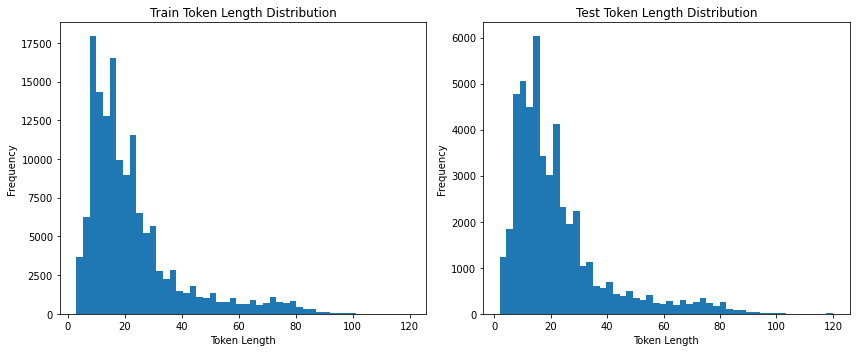

In [41]:
# 1) 토큰 길이 리스트 생성
train_lengths = [len(ids) for ids in train_tokenized['input_ids']]
test_lengths  = [len(ids) for ids in test_tokenized['input_ids']]

# 2) 요약 통계 계산
stats = pd.DataFrame({
    'Dataset':    ['Train', 'Test'],
    'Min Length': [min(train_lengths), min(test_lengths)],
    'Max Length': [max(train_lengths), max(test_lengths)],
    'Avg Length': [sum(train_lengths)/len(train_lengths), sum(test_lengths)/len(test_lengths)],
})
print(stats)

# 3) 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(train_lengths, bins=50)
axes[0].set_title("Train Token Length Distribution")
axes[0].set_xlabel("Token Length")
axes[0].set_ylabel("Frequency")

axes[1].hist(test_lengths, bins=50)
axes[1].set_title("Test Token Length Distribution")
axes[1].set_xlabel("Token Length")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## 모델 학습 ( 기본 )

In [9]:
output_dir = './transformers'

training_arguments = TrainingArguments(
    output_dir,        # output이 저장될 경로
    num_train_epochs=3,
    
    # 배치 크기 (GPU 메모리에 따라 조정)
    per_device_train_batch_size=128,  
    per_device_eval_batch_size=128, 
    
    # 학습률 관련 
    learning_rate=2e-5,  
    warmup_ratio=0.1,  # 전체 step의 10% 워밍업
    
    # 정규화
    weight_decay=0.01,  # 과적합 방지
    
    # 평가 및 저장
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2, 
    
    # 기타
    fp16=True,
    seed=42,# weight decay
    report_to=[]
)

In [11]:
train_val_split = train_tokenized.train_test_split(test_size=0.2, seed=42)
trainer = Trainer(
    model=model,                    # 사전 정의된 모델
    args=training_arguments,        # 훈련 설정
    train_dataset=train_val_split['train'],     # 훈련용
    eval_dataset=train_val_split['test'],       # 검증용
    compute_metrics=compute_metrics, # 평가 메트릭 함수
    tokenizer=tokenizer,            # 토크나이저 (저장시 필요)
)


Loading cached split indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-d3ba110107d36715.arrow and /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-73cd491a853e9b34.arrow
Using amp fp16 backend


In [12]:
# GPU 메모리 정리
torch.cuda.empty_cache()
gc.collect()

trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 116940
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 2742


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.361400,0.246581,0.898037,0.897978
2,0.209400,0.253405,0.898139,0.898003
3,0.161100,0.248408,0.905356,0.905354


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 29236
  Batch size = 128
Saving model checkpoint to ./transformers/checkpoint-914
Configuration saved in ./transformers/checkpoint-914/config.json
Model weights saved in ./transformers/checkpoint-914/pytorch_model.bin
tokenizer config file saved in ./transformers/checkpoint-914/tokenizer_config.json
Special tokens file saved in ./transformers/checkpoint-914/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 29236
  Batch size = 128
Saving model checkpoint to ./transformers/checkpoint-1828
Configuration saved in ./transformers/checkpoint-1828/config.json
Model weights saved in ./transformers/checkpoint-

TrainOutput(global_step=2742, training_loss=0.23066589277561, metrics={'train_runtime': 3589.1197, 'train_samples_per_second': 97.745, 'train_steps_per_second': 0.764, 'total_flos': 2.1633895415952e+16, 'train_loss': 0.23066589277561, 'epoch': 3.0})

## 모델 평가 ( 기본 )

In [15]:
eval_metrics = trainer.evaluate(test_tokenized)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 128


In [16]:
eval_metrics

{'eval_loss': 0.2582551836967468,
 'eval_accuracy': 0.90184,
 'eval_f1': 0.9018317078654844,
 'eval_runtime': 430.6607,
 'eval_samples_per_second': 116.101,
 'eval_steps_per_second': 0.908,
 'epoch': 3.0}

## 버켓팅 적용 데이터 준비

In [25]:
lengths = nsmc["test"].map(get_token_length, batched=False)

#  최대 길이 추출
max_length = max(lengths["length"])
print(f"NSMC test set maximum token length: {max_length}")

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-26f336632953e275.arrow


NSMC test set maximum token length: 122


In [37]:
# 기존 객체 해제 - 메모리 문제 발생으로 추가
for name in [
    "model", "trainer", "exp_args", "model_for_bucket_exp", "trainer_with_bucket",
    "train_val_split", "train_dataloader",
    "eval_dataloader", "train_tokenized", "test_tokenized"
]:
    if name in globals():
        del globals()[name]
# 메모리·캐시 정리
torch.cuda.empty_cache()
gc.collect()

0

In [40]:
train_tokenized = train.map(transform_without_padding, batched=True)
test_tokenized = test.map(transform_without_padding, batched=True)

  0%|          | 0/147 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

## 모델 준비 ( Bucketing )
- 이전 모델을 그대로 사용하는 경우 학습이 된 상태에 추가로 학습이 진행되므로 모델을 pretrain 상태로 다시 받아옴

In [42]:
model_for_bucket_exp = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transform

## 모델 학습 ( Bucketing )
- DataCollatorWithPadding
- group_by_length ( 학습시에만 적용됨 )
- 메모리 문제로 인해 두가지 옵션 적용 ( 학습에만 적용, 64 size를 2번 묶어 학습 -> 128 batch 사이즈와 동일한 효과 기대 )  
    - exp_args.per_device_train_batch_size=64
    - exp_args.gradient_accumulation_steps = 2

In [43]:
# 복사
exp_args = copy.deepcopy(training_arguments)

# 복제본에만 옵션 변경
exp_args.group_by_length = True
exp_args.output_dir = './transformers_with_bucket'
exp_args.per_device_train_batch_size=64
exp_args.gradient_accumulation_steps = 2
    
# 실험용 DataCollatorWithPadding 생성
exp_data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

train_val_split = train_tokenized.train_test_split(test_size=0.2, seed=42)
# Trainer 
trainer_with_bucket = Trainer(
    model=model_for_bucket_exp,
    args=exp_args,                              # group_by_length 적용된 args
    train_dataset=train_val_split['train'],
    eval_dataset=train_val_split['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=exp_data_collator,            #  DataCollatorWithPadding
)


Using amp fp16 backend


### GPU 메모리 정리 및 메모리 확인
- 메모리 문제로  추가 학습 진행 안됨
- 메모리 정리 후 학습 진행은 확인 -> 학습 중 메모리 문제 재발생
- 기본 모델 및 GPU 메모리에 존재 가능성이 있는 변수들 제거 후 메모리 확보 확인 -> 학습 중 메모리 문제 여전히 발생
- 동적 패딩시 메모리를 적게 사용한다고 일반적으로 알려져 있으나 실제로 동적패딩시에 OOM 문제 발생한 원인 파악
    - 동적 할당시의 다양한 크기의 텐서 생성으로 인한 파편화 가능성과 그로 인한 allocator 의 reserve 메모리가 늘어나는 문제
    - 학습을 위한 연산에 필요한 메모리가 적을 수 있으나 동적 할당을 위한 reserve 메모리로 인해 필요 메모리가 늘어남
- gradient_accumulation_steps을 2로 적용하고 batch size를 반으로 줄여 기본 학습과 같은 사이즈 학습을 기대하고 학습 진행
    - 실제 동작이 다른 부분이 존재 - 학습 분석 내용 참고

In [44]:
# GPU 메모리 정리
torch.cuda.empty_cache()
gc.collect()

print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 17        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2143 MB |   11897 MB |   43273 GB |   43271 GB |
|       from large pool |    2141 MB |   11892 MB |   42770 GB |   42768 GB |
|       from small pool |       2 MB |     115 MB |     503 GB |     503 GB |
|---------------------------------------------------------------------------|
| Active memory         |    2143 MB |   11897 MB |   43273 GB |   43271 GB |
|       from large pool |    2141 MB |   11892 MB |   42770 GB |

## 모델 학습 ( Bucketing )

In [45]:
train_output_with_bucket = trainer_with_bucket.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 116940
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 2
  Total optimization steps = 2742


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.382300,0.253201,0.896942,0.896806
2,0.212800,0.244824,0.900260,0.900208
3,0.163300,0.250799,0.904228,0.904224


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 29236
  Batch size = 128
Saving model checkpoint to ./transformers_with_bucket/checkpoint-914
Configuration saved in ./transformers_with_bucket/checkpoint-914/config.json
Model weights saved in ./transformers_with_bucket/checkpoint-914/pytorch_model.bin
tokenizer config file saved in ./transformers_with_bucket/checkpoint-914/tokenizer_config.json
Special tokens file saved in ./transformers_with_bucket/checkpoint-914/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 29236
  Batch size = 128
Saving model checkpoint to ./transformers_with_bucket/checkpoint-1828
Configuration saved in ./transformers_with_

In [46]:
train_output_with_bucket

TrainOutput(global_step=2742, training_loss=0.23688198231503008, metrics={'train_runtime': 1453.9202, 'train_samples_per_second': 241.292, 'train_steps_per_second': 1.886, 'total_flos': 4324205528180160.0, 'train_loss': 0.23688198231503008, 'epoch': 3.0})

## 모델 평가 ( Bucketing )

In [47]:
eval_metrics_with_bucket = trainer_with_bucket.evaluate(test_tokenized)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 128


In [48]:
eval_metrics_with_bucket

{'eval_loss': 0.2560597062110901,
 'eval_accuracy': 0.90188,
 'eval_f1': 0.9018726138861791,
 'eval_runtime': 325.9863,
 'eval_samples_per_second': 153.381,
 'eval_steps_per_second': 1.199,
 'epoch': 3.0}

## 실험 내용 분석

### 패딩 시각화 분석
- batch 별 토큰 길이 및 패딩 길이 
- 해당 batch 에 동적 패딩이 아닌 max padding 적용시 패딩 길이

#### 학습 데이터 패딩 시각화
- 학습시에는 group by padding과 batch 별 동적 패딩이 모두 적용됨
- 동적 패딩의 특징 padding 최소값이 모두 0, 패딩그룹화시에는 MAX 및 평균도 대체로 작음
- batch수가 많아 확인 결과 동적 패딩 적용 기준이 accumulation_steps 과 상관없이 device batch 기준으로 적용됨
    - 패딩 길이 등은 64 batch size를 했을때와 같게됨
    - 학습은 2개 batch를 묶어서 진행되므로 128 size를 적용했을때와 유사하지만 batch 별 max length 가 다를 수 있으므로 미세 차이가 있을 수 있음
- max length 와 전체 데이터를 처리하면서 처리되는 패딩수 차이가 데이터 당 평균 100개에 가까워 보임
    - max 적용시와 동적 패딩을 적용 안했을때와 batch별 분포가 다르므로 최소값 최대값은 의미가 없을 수 있으나 전체 적용 패딩수는 같음

In [49]:
# train DataLoader 가져오기
train_dataloader = trainer_with_bucket.get_train_dataloader()

df_stats = pdding_stat_batch(train_dataloader)
df_stats


The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.


,min_len,max_len,avg_len,pad_min,pad_max,pad_avg,fixed_pad_min,fixed_pad_max,fixed_pad_avg
0,75,120,83.484375,0,45,36.515625,0,45,36.515625
1,66,75,71.109375,0,9,3.890625,45,54,48.890625
2,58,66,61.578125,0,8,4.421875,54,62,58.421875
3,50,58,53.906250,0,8,4.093750,62,70,66.093750
4,46,50,47.750000,0,4,2.250000,70,74,72.250000
...,...,...,...,...,...,...,...,...,...
1823,9,10,9.406250,0,1,0.593750,110,111,110.593750
1824,8,9,8.484375,0,1,0.515625,111,112,111.515625
1825,7,8,7.281250,0,1,0.718750,112,113,112.718750
1826,4,6,5.421875,0,2,0.578125,114,116,114.578125


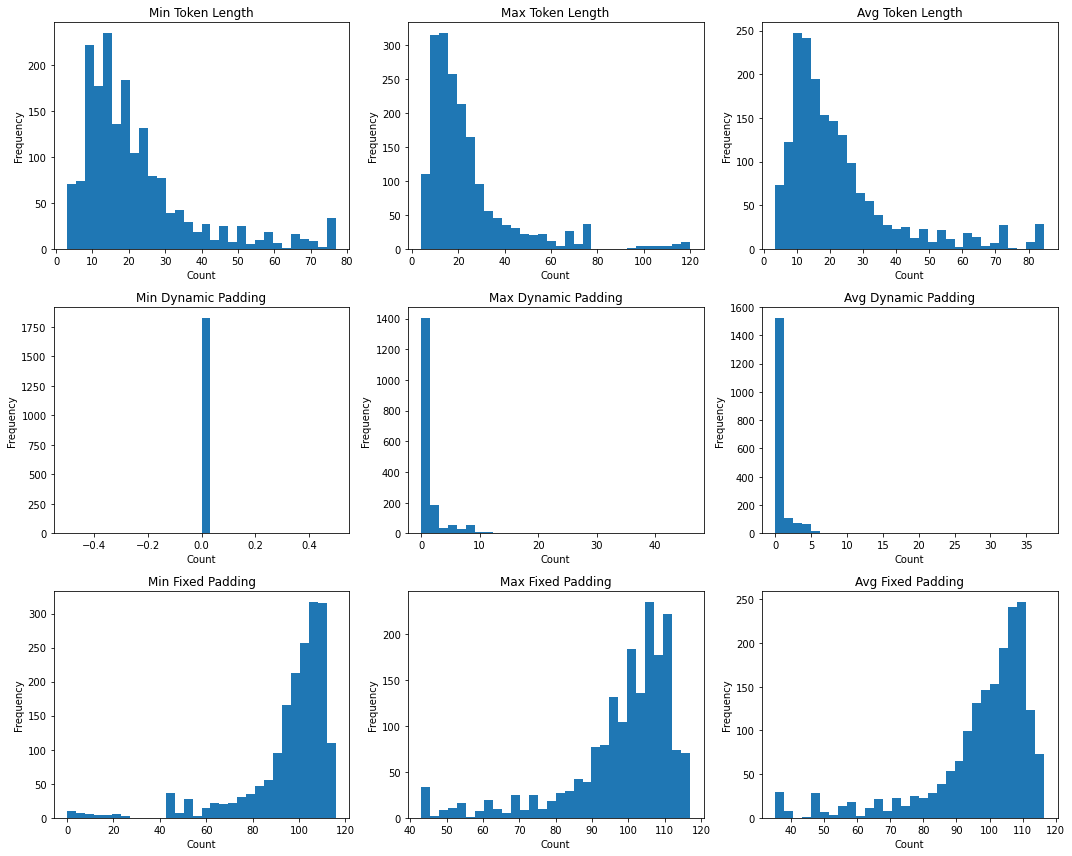

In [50]:
plot_padding_stat_batch(df_stats)

#### 검증 데이터 패딩 시각화
- 토큰수를 봤을때 길이 분포가 어느정도 분산되어 적용되었음을 확인
- 검증 데이터는 group by padding 적용 안됨, batch별 동적 패딩만 적용됨
- 패딩별 그룹화 없이 배치 동적 패딩만 적용되었어도 평균적으로 20~30개 정도의 차이를 보이는 것으로 보임

In [51]:
# eval DataLoader 가져오기
eval_dataloader = trainer_with_bucket.get_eval_dataloader()

df_stats = pdding_stat_batch(eval_dataloader)
df_stats

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.


,min_len,max_len,avg_len,pad_min,pad_max,pad_avg,fixed_pad_min,fixed_pad_max,fixed_pad_avg
0,4,95,21.937500,0,91,73.062500,25,116,98.062500
1,3,93,21.937500,0,90,71.062500,27,117,98.062500
2,4,89,21.320312,0,85,67.679688,31,116,98.679688
3,3,70,21.867188,0,67,48.132812,50,117,98.132812
4,3,77,21.851562,0,74,55.148438,43,117,98.148438
...,...,...,...,...,...,...,...,...,...
224,5,81,21.867188,0,76,59.132812,39,115,98.132812
225,3,88,22.562500,0,85,65.437500,32,117,97.437500
226,5,95,22.140625,0,90,72.859375,25,115,97.859375
227,4,75,23.156250,0,71,51.843750,45,116,96.843750


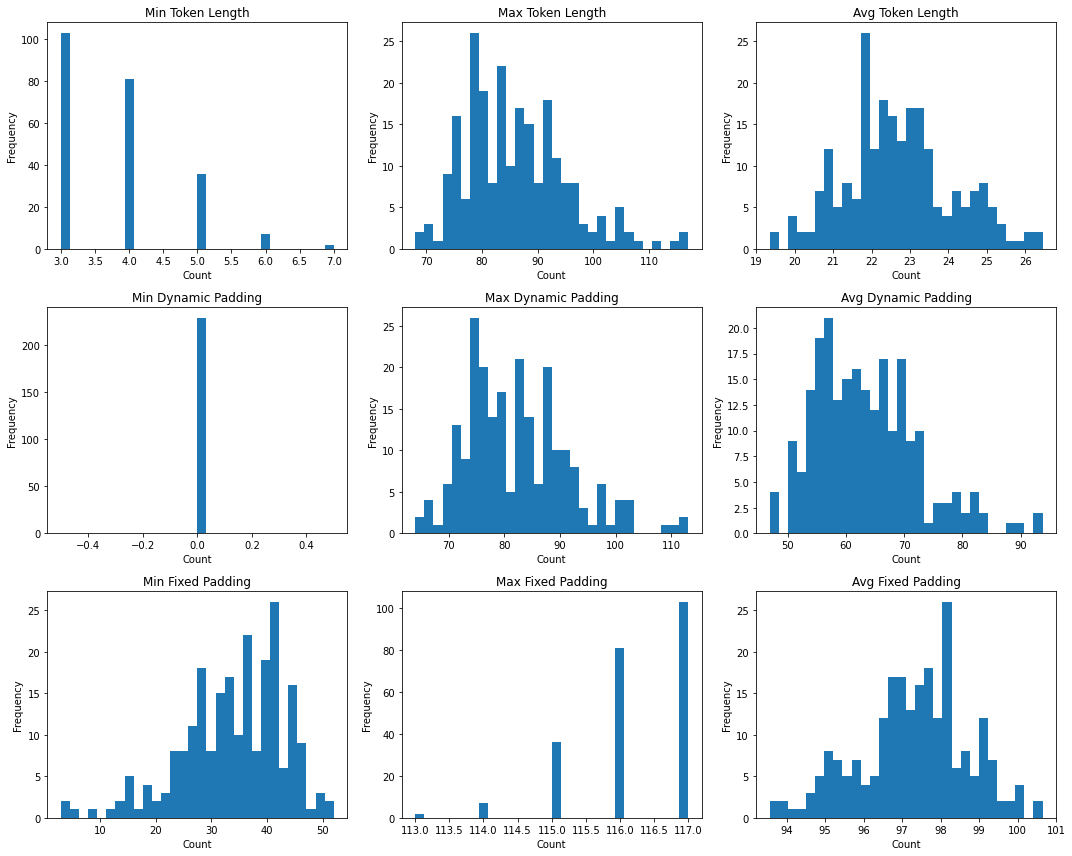

In [52]:
plot_padding_stat_batch(df_stats)

#### 테스트 데이터 패딩 시각화
- 검증 데이터와 유사한 분포를 보임 
- group by length 적용 안됨, batch별 동적 패딩만 적용됨

In [56]:
test_tokenized

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 50000
})

In [57]:
from torch.utils.data import DataLoader, SequentialSampler

test_tokenized.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]  # 필요에 따라 컬럼 추가
)


test_dataloader = DataLoader(
    test_tokenized,
    sampler=SequentialSampler(test_tokenized),               # Trainer 내부와 동일
    batch_size=training_arguments.per_device_eval_batch_size,
    collate_fn=exp_data_collator,
    drop_last=False,                                         # Trainer 기본값
)

df_stats = pdding_stat_batch(test_dataloader)
df_stats

,min_len,max_len,avg_len,pad_min,pad_max,pad_avg,fixed_pad_min,fixed_pad_max,fixed_pad_avg
0,3,94,22.070312,0,91,71.929688,26,117,97.929688
1,3,81,22.187500,0,78,58.812500,39,117,97.812500
2,4,76,22.453125,0,72,53.546875,44,116,97.546875
3,3,96,21.390625,0,93,74.609375,24,117,98.609375
4,3,80,22.382812,0,77,57.617188,40,117,97.617188
...,...,...,...,...,...,...,...,...,...
386,3,92,24.500000,0,89,67.500000,28,117,95.500000
387,3,106,20.843750,0,103,85.156250,14,117,99.156250
388,3,81,24.070312,0,78,56.929688,39,117,95.929688
389,4,91,24.523438,0,87,66.476562,29,116,95.476562


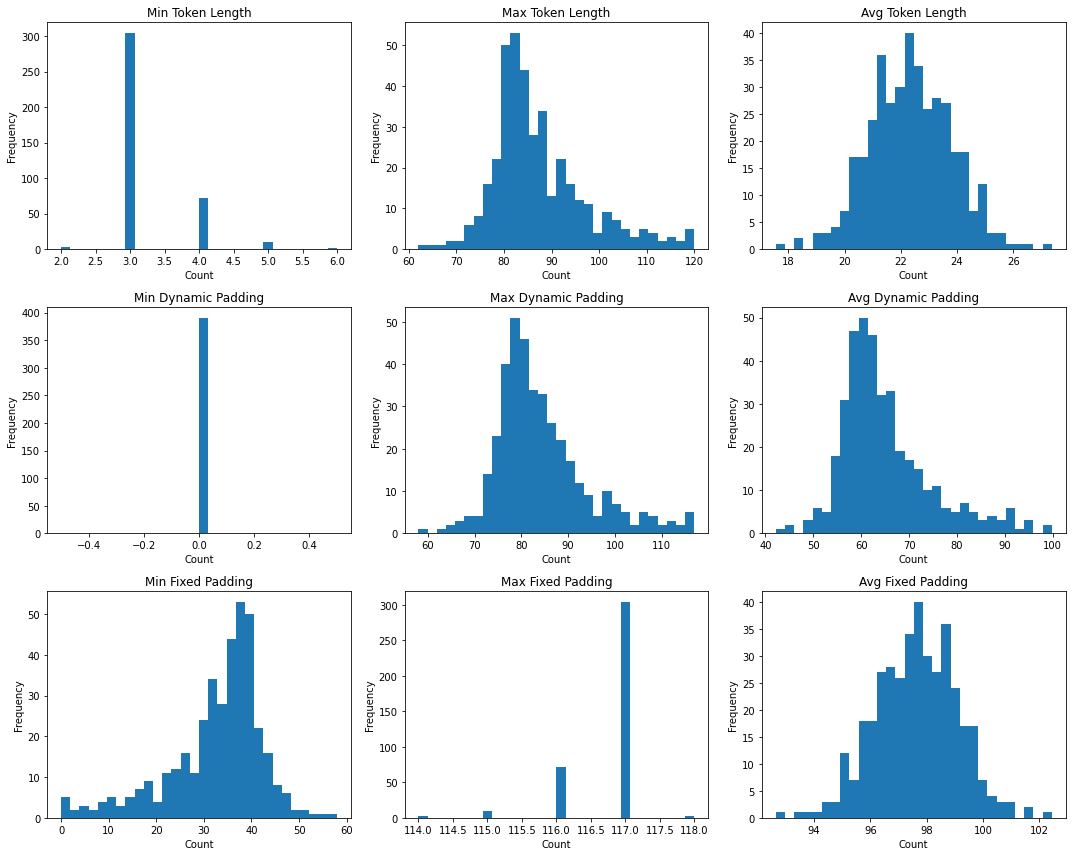

In [58]:
plot_padding_stat_batch(df_stats)

#### 추가 테스트 시각화 ( 테스트 데이터 토큰 길이로 정렬 )
- group by length 적용 효과와 같은 효과 기대
- 실제로 train data 와 유사한 분포를 보임
- 패딩의 Max 및 평균이 group by length 대비 더 짧은 경향
    - group by length가 가장 짧은 패딩을 생성하기 위해 최적화된 그룹을 생성하는 것이 아닌 길이 구간별 버켓을 만들고 같은 버켓 안에서 그룹 데이터를 선택하는 방식으로 동작함으로 인한 차이

In [66]:
import time

start = time.time()
# length 컬럼 추가
test_with_len = test_tokenized.map(
    lambda x: {"length": len(x["input_ids"])},
    batched=False
)

# length 기준으로 정렬
test_sorted = test_with_len.sort("length")

# 불필요해진 length 컬럼 제거
test_tokenized_sorted = test_sorted.remove_columns("length")
end = time.time()
print(f"Elapsed: {end - start:.2f} seconds")

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-c29323ed9fbe3849.arrow
Loading cached sorted indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-d83c09595c8a760b.arrow


Elapsed: 0.01 seconds


In [59]:
eval_metrics_with_bucket = trainer_with_bucket.evaluate(test_tokenized_sorted)

  0%|          | 0/50000 [00:00<?, ?ex/s]

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 128


In [60]:
eval_metrics_with_bucket

{'eval_loss': 0.2560596764087677,
 'eval_accuracy': 0.90188,
 'eval_f1': 0.9018726138861791,
 'eval_runtime': 101.0823,
 'eval_samples_per_second': 494.647,
 'eval_steps_per_second': 3.868,
 'epoch': 3.0}

In [64]:
from torch.utils.data import DataLoader, SequentialSampler

test_tokenized_sorted.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]  # 필요에 따라 컬럼 추가
)


test_sorted_dataloader = DataLoader(
    test_tokenized_sorted,
    sampler=SequentialSampler(test_tokenized_sorted),               # Trainer 내부와 동일
    batch_size=training_arguments.per_device_eval_batch_size,
    collate_fn=exp_data_collator,
    drop_last=False,                                         # Trainer 기본값
)

df_stats = pdding_stat_batch(test_sorted_dataloader)
df_stats

,min_len,max_len,avg_len,pad_min,pad_max,pad_avg,fixed_pad_min,fixed_pad_max,fixed_pad_avg
0,2,3,2.976562,0,1,0.023438,117,118,117.023438
1,3,3,3.000000,0,0,0.000000,117,117,117.000000
2,3,3,3.000000,0,0,0.000000,117,117,117.000000
3,3,3,3.000000,0,0,0.000000,117,117,117.000000
4,3,4,3.203125,0,1,0.796875,116,117,116.796875
...,...,...,...,...,...,...,...,...,...
386,80,82,80.953125,0,2,1.046875,38,40,39.046875
387,82,84,82.593750,0,2,1.406250,36,38,37.406250
388,84,87,85.257812,0,3,1.742188,33,36,34.742188
389,87,94,89.960938,0,7,4.039062,26,33,30.039062


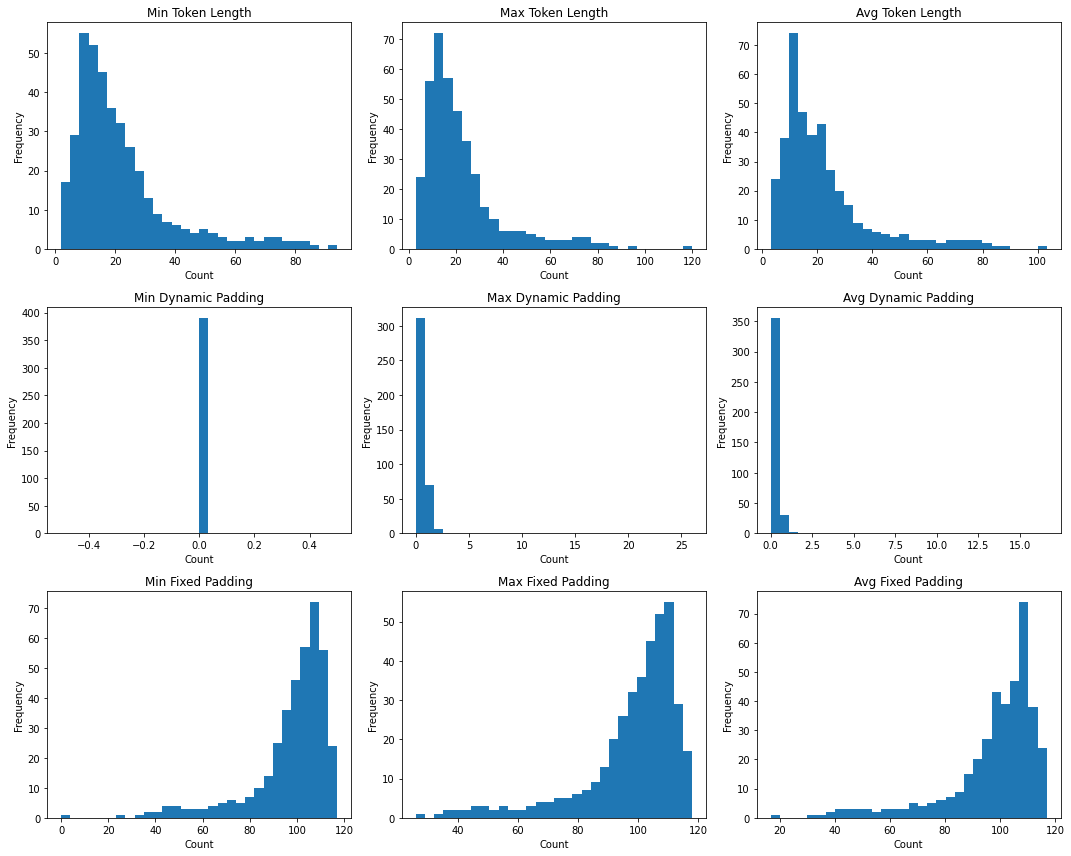

In [65]:
plot_padding_stat_batch(df_stats)

### 학습 분석
- 공통 
    - Num examples = 116940
    - Num Epochs = 3
    - Total train batch size (w. parallel, distributed & accumulation) = 128
    - Total optimization steps = 2742 (모델 파라미터 업데이트 step)
- 기본 모델과 Bucket 차이
    - Instantaneous batch size per device ( 기본 : 128  , Bucket : 64 )
    - Gradient Accumulation steps ( 기본 : 1, Bucket : 2 )
    - 동적 패딩 및 group by length 적용 ( 기본 : 미적용, Bucket : 적용 )
- 학습 시간 및 연산 비용
    - bucket의 학습 시간은 기본 대비 약 40%, flos 는 약 20% ( 왜 비례하지 않을까? )
        - accumulation 적용은 flos에는 영향이 거의 없고 오버헤드로 인해 시간 5~15% 지연 가능성이 있음
        - 동적 패딩 적용시 flos는 토큰 길이의 제곱에 비례하지만 시간은 flos 변화와 패딩 적용을 위한 오버헤드에 영향받음
        - 종합적으로 보면 accumulation 으로 인한 오버헤드가 오히려 추가되었으나 동적 패딩 적용으로 연산량이 줄면서 시간 감소
    - bucket 적용에 따른 연산 비용 및 시간
        - 연산 비용(flos) : 데이터 길이가 짧은 분포가 많을수록 패딩이 많이 줄어들어 연산비용 감소
        - 연산 오버헤드 : 동적 패딩 적용을 위한 버켓 생성 및 추출, 그리고 최대길이로의 패딩추가등의 시간 필요
        - 연산 비용 감소로 인한 이득과 오버헤드를 비교해 연산 비용 감소로 인한 이득이 큰 경우에만 적용 효과를 볼 수 있음
 
- 학습 
    - 평균 훈련 loss 나 최종 loss 모두 baseline 이 낮지만 미미한 차이로 보임
    - bucket 의 경우 group by length 적용시 batch 별 학습 길이에 따른 편향된 정보가 학습될 가능성이 있음

- 검증
    - epoch 별 메트릭 외에 검증 관련 내용 기록이 없음 메트릭만 분석
    - train loss와 마찬가지로 accuracy나 f1 모두 기본이 미미하게 좋음
    - 검증시에는 group by length가 적용되지 않음 -> 학습 과정에서 편향 가능성을 줄여주는 역활을 할 것으로 기대
    - 검증 시간 로그가 남지 않아 검증 시간에 대한 분석은 제외 ( 테스트와 비슷하니 테스트 분석에서 분석 )

 * 기본 모델 훈련 정보를 변수에 저장 안한 상태에서 모델과 trainer를 지워서 로그를 토대로 결과 표시

In [76]:
pd.DataFrame([{'train_runtime': 3589.1197, 'train_samples_per_second': 97.745, 'train_steps_per_second': 0.764, 'total_flos': 2.1633895415952e+16, 'train_loss': 0.23066589277561, 'epoch': 3.0},{'train_runtime': 1453.9202, 'train_samples_per_second': 241.292, 'train_steps_per_second': 1.886, 'total_flos': 4324205528180160.0, 'train_loss': 0.23688198231503008, 'epoch': 3.0}],
    index=["baseline", "bucket"])


,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,epoch
baseline,3589.1197,97.745,0.764,2.163390e+16,0.230666,3.0
bucket,1453.9202,241.292,1.886,4.324206e+15,0.236882,3.0


### 테스트 분석
- 공통
    - Num examples = 50000
    - Batch size = 128
- 기본 모델과 Bucket 및 sort 차이
    - 동적 패딩 적용 : bucket , bucket&sort
    - 모두 순서대로 group 화 되나 bucket&sort의 경우 순서를 길이 순으로 정렬해 group by length 와 유사한 효과를 줌
- 테스트 평가지표 
    - bucket 적용시의 지표가 미세하게 좋으나 이 역시 미미함
    - bucket 적용시 그로 인한 모델 성능 상의 향상이나 저해가 없는 것으로 보임 ( 다른 설정이나 데이터에서는 다를 수 있음 )
- 테스트 속도
    - 테스트 속도 면에서는 bucket&sort, bucket, baseline 순으로 좋은 것으로 나타남
    - 학습에서 시간에 대해 분석한 내용과 마찬가지로 패딩에 따른 연산 및 오버헤드로 인한 영향으로 보임
    - 동적 패딩 사용시 테스트용 데이터를 길이로 정렬하는 경우 결과에는 영향을 미치지 않고 속도가 향상됨
    - 본 실험 데이터 정렬에 드는 시간은 0.01초로 시간 대비 오버헤드는 거의 없는 수준으로 정렬시 시간 단축 효과를 볼 수 있음
    - 일반화해보면 토큰 길이 분포 등에 따라 영향이 있을 수 있으므로 오버헤드 대비 시간 이득에 따라 정렬을 사용하면 학습시간을 단축할 수 있을 것으로 보임 

In [77]:
pd.DataFrame([
    {'eval_loss': 0.2582551836967468,
     'eval_accuracy': 0.90184,
     'eval_f1': 0.9018317078654844,
     'eval_runtime': 430.6607,
     'eval_samples_per_second': 116.101,
     'eval_steps_per_second': 0.908,
     'epoch': 3.0},
    {'eval_loss': 0.2560597062110901,
     'eval_accuracy': 0.90188,
     'eval_f1': 0.9018726138861791,
     'eval_runtime': 325.9863,
     'eval_samples_per_second': 153.381,
     'eval_steps_per_second': 1.199,
     'epoch': 3.0},

     {'eval_loss': 0.2560596764087677,
     'eval_accuracy': 0.90188,
     'eval_f1': 0.9018726138861791,
     'eval_runtime': 101.0823,
     'eval_samples_per_second': 494.647,
     'eval_steps_per_second': 3.868,
     'epoch': 3.0}
    ],
    index=["baseline", "bucket","bucket&sort"])

,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
baseline,0.258255,0.90184,0.901832,430.6607,116.101,0.908,3.0
bucket,0.256060,0.90188,0.901873,325.9863,153.381,1.199,3.0
bucket&sort,0.256060,0.90188,0.901873,101.0823,494.647,3.868,3.0


## 회고
#### 좋았던 점
- batch 별 패딩을 확인한 점
    - 추가 실험시 토크나이징 후 split 함수 적용을 빼먹어 이전 학습에 사용된 split 데이터를 사용하여 이번 모델과 패딩수가 같게 나온적이 있는데 패딩을 확인하지 않았다면 결과가 비슷하다라는 결론을 내리고 넘어갔을듯함
    - 학습 과정과 검증과정에서 group by length가 다르게 적용된다 등 추가적으로 알 수 있는 부분이 있었고 분석 과정에서 더 궁금한 것들이 생겨 알아보다 보니 더 많은 것을 공부할 수 있었음
    
#### 아쉬운 점
- 메모리로 인해 batch size 128을 적용하지 못하고 size 64 에 2 step에 한번 optimize하도록 적용한 부분 
    - 동일 batch 처럼 학습하는 것을 기대했으나 실제로는 64와 더 비슷한 동작
- 팀이 적용한 것들을 고려해 큰 batch를 잡아 문제가 있어 팀 결과를 취합해보지 못한 부분
- 기본적은 남는 로그들과 데이터를 이용했는데 추가적으로 로그와 기록을 남겨서 실험했으면 하는 부분이 있음 
    - 예를 들어 검증시간이나 실제 peak 메모리등 


#### 배운 점 
- 메모리 이슈로 인해서 메모리 부족을 해결하는 과정에서 메모리 관리 관련 부분에 대해 더 자세히 이해
- 메모리를 해결하는 과정에서 accumulation_steps 를 적용하고 결과를 분석하는 과정에서 학습 과정과 optimization 과정에 batch 관련 좀 더 자세히 공부함
- 분석 과정에서 bucket 과 연산비용 시간과의 관계 및 버켓의 좀 더 세부적인 동작등에 대해서 알게되었음

#### 나중에 추가로 해볼만한 부분
- batch size 128에 bucketing을 적용해 bucketing 만 다른 경우를 추가 실험
- 팀원들의 결과를 github를 통해 확인하고 비교해 보는 것도 의미가 있을 수 있음
- 데이터 길이 분포가 다른 데이터에 대한 버케팅 적용시 실제 학습 시간등 비교
- 길이 편향이 발생하는지 확인 -  구간별 차이가 있는지 확인

#### 개인적 회고
- 분석하고 알아보는것은 재밌는데 이걸 정리해서 보고서 형식으로 잘 전달하는건 어렵기도하지만 매우 귀찮은 작업이다. 하지만 이런건 잘해야되는데라고 생각함
- 비교 실험을 하다보면 다하고 나면 그제서야 이것을 기록할걸 이걸 해볼걸하는 것들이 늘 있는 것 같다. 아쉽지만 또 다른 실험이나 다른 프로젝트를 할 때 생각했던 부분들을 적용해볼 수 있으니 그런 아쉬움도 공부의 영역으로 남겨야할 것 같다.
